In [1]:
import pandas as pd

insurance_df = pd.read_csv("../data/insurance.csv")

In [2]:
##Converting objects labels into categorical
insurance_df[['sex', 'smoker', 'region']] = insurance_df[['sex', 'smoker', 'region']].astype('category')
insurance_df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [3]:
##Converting category labels into numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(insurance_df.sex.drop_duplicates())
insurance_df.sex = label.transform(insurance_df.sex)
label.fit(insurance_df.smoker.drop_duplicates())
insurance_df.smoker = label.transform(insurance_df.smoker)
label.fit(insurance_df.region.drop_duplicates())
insurance_df.region = label.transform(insurance_df.region)
insurance_df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

### <font color='yellow'>**① 予測精度の評価**</font>

In [4]:
from sklearn.model_selection import train_test_split as holdout

x = insurance_df.drop(['charges'], axis = 1)
y = insurance_df['charges']
x_train, x_test, y_train, y_test = holdout(x, y, test_size=0.2, random_state=0)

In [5]:

from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn import metrics

x = insurance_df.drop(['charges'], axis=1)
y = insurance_df.charges

Rfr = rfr(
    n_estimators = 100, 
    criterion = 'friedman_mse',
    random_state = 1,
    n_jobs = -1
)

Rfr.fit(x_train, y_train)
x_train_pred = Rfr.predict(x_train)
x_test_pred = Rfr.predict(x_test)

print(
    'MSE train data: %.3f, MSE test data: %.3f' % 
    (metrics.mean_squared_error(x_train_pred, y_train), metrics.mean_squared_error(x_test_pred, y_test))
)
print(
    'R2 train data: %.3f, R2 test data: %.3f' % 
    (metrics.r2_score(y_train, x_train_pred), metrics.r2_score(y_test, x_test_pred))
)

MSE train data: 3627543.313, MSE test data: 19580381.390
R2 train data: 0.975, R2 test data: 0.877


In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ランダムフォレスト回帰モデルの初期化
rfr = rfr(
    n_estimators=100, 
    criterion='friedman_mse', 
    random_state=1, 
    n_jobs=-1
)

# 交差検証のためのKFoldを設定
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# MSE と R2 のスコアを格納するリスト
mse_scores = []
r2_scores = []

# KFold交差検証を実行
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # モデルを学習
    rfr.fit(x_train, y_train)
    
    # 予測を行う
    y_pred = rfr.predict(x_test)
    
    # MSE と R2 を計算してリストに追加
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# MSE と R2 の平均値を出力
print('Average MSE:', np.mean(mse_scores))
print('Average R2:', np.mean(r2_scores))


Average MSE: 23599074.555143476
Average R2: 0.8383297784633121


In [8]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# パラメータの組み合わせを定義
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse']
}

# ランダムフォレスト回帰モデルの初期化
rfr = rfr(random_state=1)

# GridSearchCVの初期化
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# グリッドサーチを実行
grid_search.fit(x, y)

# 最適なパラメータとその時のMSEを表示
print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# 最適なパラメータでモデルを再学習し、R2スコアを計算する場合
best_rfr = grid_search.best_estimator_
predictions = best_rfr.predict(x)
print("R2 Score:", r2_score(y, predictions))


Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best MSE: 21135438.131923072
R2 Score: 0.9171959781219208


### <font color='yellow'>**② 相関のある変数の除去**</font>

               age       sex       bmi  children    smoker    region   charges
age       1.000000  0.020856  0.109272  0.042469  0.025019  0.002127  0.299008
sex       0.020856  1.000000  0.046371  0.017163  0.076185  0.004588  0.057292
bmi       0.109272  0.046371  1.000000  0.012759  0.003750  0.157566  0.198341
children  0.042469  0.017163  0.012759  1.000000  0.007673  0.016569  0.067998
smoker    0.025019  0.076185  0.003750  0.007673  1.000000  0.002181  0.787251
region    0.002127  0.004588  0.157566  0.016569  0.002181  1.000000  0.006208
charges   0.299008  0.057292  0.198341  0.067998  0.787251  0.006208  1.000000


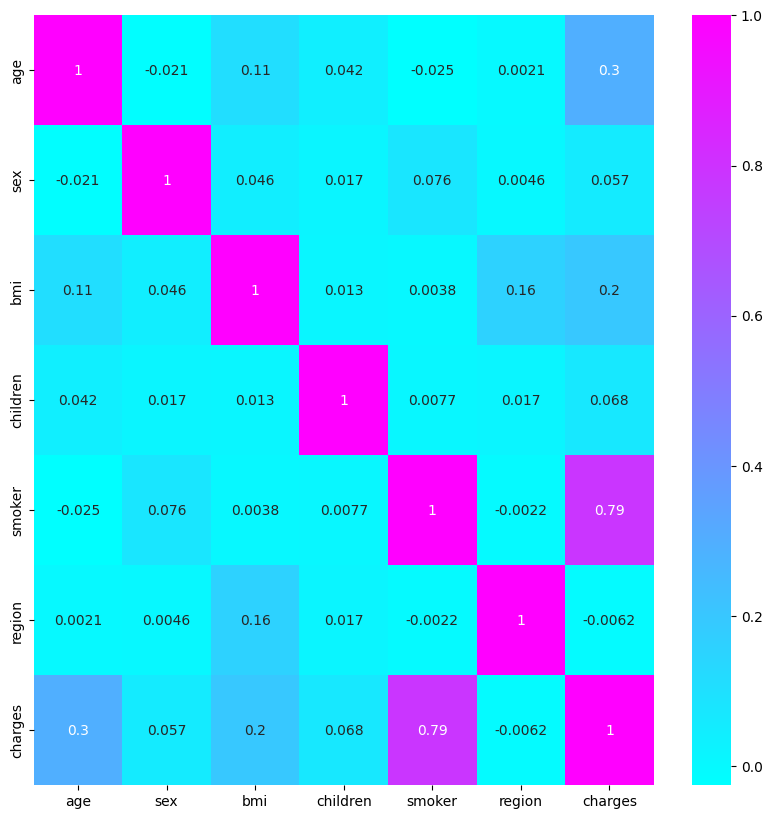

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = insurance_df.corr().abs()

print(corr_matrix)

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(insurance_df.corr(), annot=True, cmap='cool')

In [11]:
threshold = 0.7

# 閾値以上の相関を持つ変数のペアを見つける
high_corr_var = np.where(corr_matrix > threshold)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# 取り除く変数のリストを作成（一方の変数のみを取り除く）
vars_to_remove = []
for var_pair in high_corr_var:
    vars_to_remove.append(var_pair[1])  # 2つの変数のうち、後者を削除対象とする

# 取り除く変数のリストから重複を削除
vars_to_remove = list(set(vars_to_remove))

# 高い相関を持つ変数を取り除いたデータフレームの作成
reduced_df = insurance_df.drop(columns=vars_to_remove)

# 取り除いた変数の表示
print("Removed variables:", vars_to_remove)


Removed variables: ['charges']


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import mean_squared_error, r2_score

# 元のデータセットと変数を削除したデータセットでの学習と評価
for dataset, label in zip([insurance_df, reduced_df], ['Original', 'Reduced']):
    # 特徴量とターゲット変数の分離
    X = insurance_df.drop(['charges'], axis=1)
    y = insurance_df['charges']

    
    # 学習データとテストデータの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # モデルの学習
    model = rfr(
        criterion='squared_error',
        max_depth=10,
        min_samples_leaf=4,
        min_samples_split=2,
        n_estimators=200,
        )
    model.fit(X_train, y_train)
    
    # テストデータでの予渲と評価
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 結果の出力
    print(f"{label} Data - MSE: {mse:.3f}, R2: {r2:.3f}")


Original Data - MSE: 18287126.628, R2: 0.877
Reduced Data - MSE: 18277838.426, R2: 0.878
